In [62]:
import sqlite3
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Connect to database
conn = sqlite3.connect('/Users/Marcy_Student/TeamHousing/data/processed/nyc_demolitions.db')

query = """
SELECT job_typeid, ownership_id
FROM fact_demolitions
"""

df = pd.read_sql_query(query, conn)

# Create demolition indicator (2 = Demolition)
df['is_demolition'] = (df['job_typeid'] == 2).astype(int)

# Affordable = ownership_id 2 & 3
df['is_affordable'] = df['ownership_id'].isin([2, 3]).astype(int)

# Split groups
affordable = df[df['is_affordable'] == 1]
forprofit = df[df['is_affordable'] == 0]

# Count demolitions in each group
count = np.array([
    affordable['is_demolition'].sum(),
    forprofit['is_demolition'].sum()
])

# Total observations in each group
nobs = np.array([
    len(affordable),
    len(forprofit)
])

# Safety check
if np.any(nobs == 0):
    print("Error: One group has zero observations.")
elif np.all(count == 0):
    print("Error: No demolitions found in either group.")
else:
    stat, p_value = proportions_ztest(count, nobs, alternative='larger')

    print("Affordable demolition proportion:", count[0] / nobs[0])
    print("For-profit demolition proportion:", count[1] / nobs[1])
    print("Z-stat:", stat)
    print("P-value:", p_value)


Affordable demolition proportion: 0.3032128514056225
For-profit demolition proportion: 0.27143652561247217
Z-stat: 2.175627925063663
P-value: 0.014791546756534511


In [63]:
print(df['job_typeid'].value_counts())


job_typeid
1    11162
2     4202
Name: count, dtype: int64


In [64]:
from scipy.stats import ttest_ind

query = """
SELECT report_date, shelter_count
FROM fact_shelters
ORDER BY report_date
"""

df = pd.read_sql_query(query, conn)

# Ensure proper date format
df['report_date'] = pd.to_datetime(df['report_date'])

# Split into two equal halves
midpoint = len(df) // 2

early_period = df.iloc[:midpoint]['shelter_count']
late_period = df.iloc[midpoint:]['shelter_count']

# Welch's t-test (does not assume equal variance)
t_stat, p_two_sided = ttest_ind(late_period, early_period, equal_var=False)

# Convert to one-sided (testing Late > Early)
if t_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - (p_two_sided / 2)

print("Mean Early Period:", early_period.mean())
print("Mean Late Period:", late_period.mean())
print("T-statistic:", t_stat)
print("One-sided P-value:", p_one_sided)

# this is not optimal, only checks difference in size not time


Mean Early Period: 42515.82142857143
Mean Late Period: 44687.42857142857
T-statistic: 0.9650979348362486
One-sided P-value: 0.16926419736587484


In [65]:
import statsmodels.api as sm

query = """
SELECT report_date, shelter_count
FROM fact_shelters
ORDER BY report_date
"""

df = pd.read_sql_query(query, conn)

# Convert date column properly
df['report_date'] = pd.to_datetime(df['report_date'])

# Sort to ensure proper time order
df = df.sort_values('report_date')

# Create numeric time trend
df['time_index'] = np.arange(len(df))

# Define regression variables
X = sm.add_constant(df['time_index'])
y = df['shelter_count']

# ---------
# OLS WITH HAC STANDARD ERRORS
# ---------

model = sm.OLS(y, X).fit(
    cov_type='HAC',
    cov_kwds={'maxlags': 1}   # 1 lag is typical for monthly data
)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          shelter_count   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     6.922
Date:                Sat, 14 Feb 2026   Prob (F-statistic):            0.00974
Time:                        21:22:56   Log-Likelihood:                -1202.2
No. Observations:                 112   AIC:                             2408.
Df Residuals:                     110   BIC:                             2414.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.651e+04   2052.535     17.789      0.0

A linear time trend regression indicates a statistically significant upward trend in shelter counts over time. After correcting for autocorrelation using Newey–West standard errors, the estimated increase is approximately 128 individuals per period (β = 127.7, p = 0.009). This provides evidence of a sustained increase in homelessness during the sample period

In [66]:
from scipy import stats

query = """
SELECT borough, time_of_completion
FROM fact_demolitions
"""

df = pd.read_sql_query(query, conn).dropna()

groups = [
    group['time_of_completion'].values
    for name, group in df.groupby('borough')
]

f_stat, p_value = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("P-value:", p_value)


F-statistic: 98.98441740921045
P-value: 2.5149106252357457e-83


In [67]:
from scipy.stats import ttest_ind

query = "SELECT time_of_completion FROM fact_demolitions"

df = pd.read_sql_query(query, conn).dropna()

q25 = df['time_of_completion'].quantile(0.25)
q75 = df['time_of_completion'].quantile(0.75)

lower = df[df['time_of_completion'] <= q25]['time_of_completion']
upper = df[df['time_of_completion'] >= q75]['time_of_completion']

t_stat, p_value = ttest_ind(lower, upper, equal_var=False)

print("25th percentile mean:", lower.mean())
print("75th percentile mean:", upper.mean())
print("T-stat:", t_stat)
print("P-value:", p_value)


25th percentile mean: 153.7583246618106
75th percentile mean: 2816.042686100989
T-stat: -120.53651717543569
P-value: 0.0


In [68]:
from scipy.stats import ttest_ind

query = """
SELECT report_date, shelter_count
FROM fact_shelters
ORDER BY report_date
"""

df = pd.read_sql_query(query, conn)

df['report_date'] = pd.to_datetime(df['report_date'])

midpoint = len(df) // 2

early = df.iloc[:midpoint]['shelter_count']
late = df.iloc[midpoint:]['shelter_count']

t_stat, p_two = ttest_ind(late, early, equal_var=False)

if t_stat > 0:
    p_one = p_two / 2
else:
    p_one = 1 - (p_two / 2)

print("Mean Early:", early.mean())
print("Mean Late:", late.mean())
print("T-stat:", t_stat)
print("One-sided P-value:", p_one)


Mean Early: 42515.82142857143
Mean Late: 44687.42857142857
T-stat: 0.9650979348362486
One-sided P-value: 0.16926419736587484


| Test                | What It Answers                                           |
| ------------------- | --------------------------------------------------------- |
| Proportion Z-test   | Is affordable ownership demolished more often?            |
| ANOVA               | Do boroughs differ in project completion speed?           |
| 25% vs 75% t-test   | Are fastest and slowest projects statistically different? |
| Homelessness t-test | Has homelessness increased over time?                     |

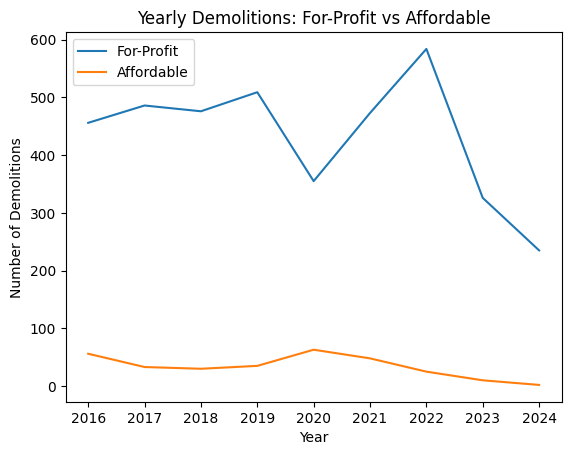

In [69]:
# Load required columns
df = pd.read_sql_query("""
SELECT month_date, job_typeid, ownership_id
FROM fact_demolitions
""", conn)

# -----------------------------
# Prepare data
# -----------------------------
df['month_date'] = pd.to_datetime(df['month_date'])
df['year'] = df['month_date'].dt.year

# Keep demolitions only (job_typeid = 2)
df = df[df['job_typeid'] == 2]

# Create ownership category
df['ownership_group'] = np.where(
    df['ownership_id'] == 1,
    "For-Profit",
    "Affordable"
)

# -----------------------------
# Aggregate yearly counts
# -----------------------------
yearly_counts = (
    df.groupby(['year', 'ownership_group'])
      .size()
      .unstack(fill_value=0)
)

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(yearly_counts.index, yearly_counts["For-Profit"])
plt.plot(yearly_counts.index, yearly_counts["Affordable"])

plt.title("Yearly Demolitions: For-Profit vs Affordable")
plt.xlabel("Year")
plt.ylabel("Number of Demolitions")
plt.legend(["For-Profit", "Affordable"])
plt.show()


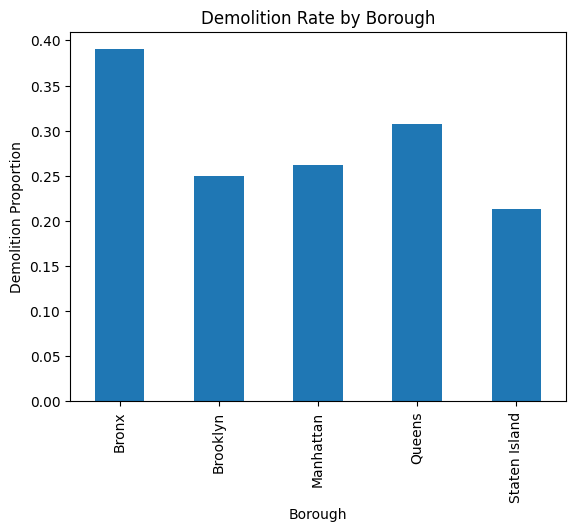

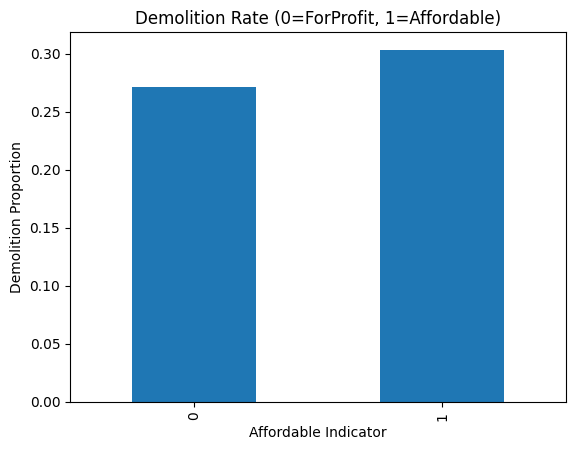

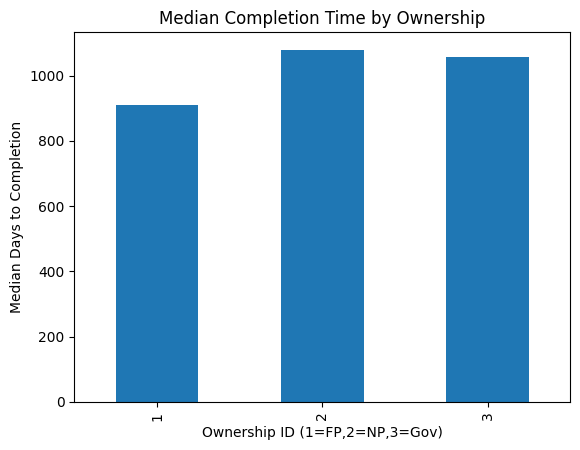

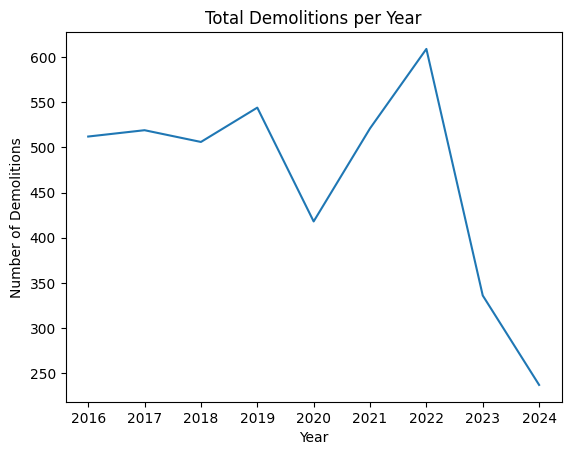

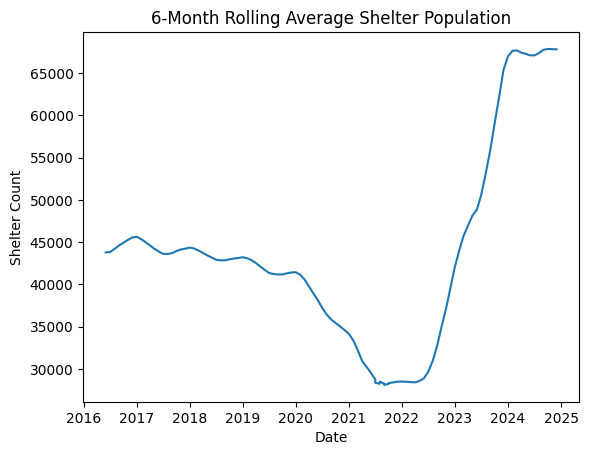

Correlation between yearly demolitions and average shelter population:
-0.8336300764002983


In [ ]:

import matplotlib.pyplot as plt

df_demo = pd.read_sql_query("""
SELECT month_date, job_typeid, ownership_id, borough, time_of_completion
FROM fact_demolitions
""", conn)

df_shelter = pd.read_sql_query("""
SELECT report_date, shelter_count
FROM fact_shelters
ORDER BY report_date
""", conn)

conn.close()

# -----------------------------
# Data Preparation
# -----------------------------
df_demo['month_date'] = pd.to_datetime(df_demo['month_date'])
df_shelter['report_date'] = pd.to_datetime(df_shelter['report_date'])

df_demo['is_demolition'] = np.where(df_demo['job_typeid'] == 2, 1, 0)
df_demo['is_affordable'] = np.where(df_demo['ownership_id'].isin([2,3]), 1, 0)

# =====================================================
# 1️⃣ Demolition Rate by Borough
# =====================================================
borough_demo_rate = df_demo.groupby('borough').agg(
    total_jobs=('job_typeid', 'count'),
    demolitions=('is_demolition', 'sum')
)

borough_demo_rate['demolition_rate'] = (
    borough_demo_rate['demolitions'] / borough_demo_rate['total_jobs']
)

plt.figure()
borough_demo_rate['demolition_rate'].plot(kind='bar')
plt.title("Demolition Rate by Borough")
plt.ylabel("Demolition Proportion")
plt.xlabel("Borough")
plt.show()

# =====================================================
# 2️⃣ Demolition Rate: Affordable vs For-Profit
# =====================================================
ownership_demo_rate = df_demo.groupby('is_affordable').agg(
    total_jobs=('job_typeid', 'count'),
    demolitions=('is_demolition', 'sum')
)

ownership_demo_rate['demolition_rate'] = (
    ownership_demo_rate['demolitions'] / ownership_demo_rate['total_jobs']
)

plt.figure()
ownership_demo_rate['demolition_rate'].plot(kind='bar')
plt.title("Demolition Rate (0=ForProfit, 1=Affordable)")
plt.ylabel("Demolition Proportion")
plt.xlabel("Affordable Indicator")
plt.show()

# =====================================================
# 3️⃣ Median Completion Time by Ownership
# =====================================================
median_completion = df_demo.groupby('ownership_id')['time_of_completion'].median()

plt.figure()
median_completion.plot(kind='bar')
plt.title("Median Completion Time by Ownership")
plt.ylabel("Median Days to Completion")
plt.xlabel("Ownership ID (1=FP,2=NP,3=Gov)")
plt.show()

# =====================================================
# 4️⃣ Yearly Demolition Trend
# =====================================================
df_demo['year'] = df_demo['month_date'].dt.year
yearly_demolitions = df_demo.groupby('year')['is_demolition'].sum()

plt.figure()
plt.plot(yearly_demolitions.index, yearly_demolitions.values)
plt.title("Total Demolitions per Year")
plt.xlabel("Year")
plt.ylabel("Number of Demolitions")
plt.show()

# =====================================================
# 5️⃣ Shelter Population Trend (Smoothed)
# =====================================================
df_shelter['rolling_avg'] = df_shelter['shelter_count'].rolling(window=6).mean()

plt.figure()
plt.plot(df_shelter['report_date'], df_shelter['rolling_avg'])
plt.title("6-Month Rolling Average Shelter Population")
plt.xlabel("Date")
plt.ylabel("Shelter Count")
plt.show()

# =====================================================
# 6️⃣ Correlation: Yearly Demolitions vs Shelter Population
# =====================================================
yearly_shelter = df_shelter.groupby(
    df_shelter['report_date'].dt.year
)['shelter_count'].mean()

combined = pd.DataFrame({
    'demolitions': yearly_demolitions,
    'avg_shelter': yearly_shelter
}).dropna()

correlation = combined.corr().iloc[0,1]

print("Correlation between yearly demolitions and average shelter population:")
print(correlation)
